In [1]:
import os
import numpy as np

In [2]:
path_to_series = os.path.join(".", "datasets", "ecg-heartbeat-av.csv")
f = open(path_to_series)
series = np.array(f.readlines(), dtype=np.double)
fs = 128  # sampling frequency

In [3]:
# uncomment this code block for the multivariate ECG example:
# path_to_series = os.path.join(".", "datasets", "mitdb_patient214.csv")
# f = open(path_to_series)
# series = np.array([line.split(',') for line in f.readlines()], dtype=np.double)
# fs = 360  # sampling frequency

In [4]:
print(series.shape)

(3001,)


In [5]:
# z-normalize time series
series = (series - np.mean(series, axis=0)) / np.std(series, axis=0)

# Parameter rho determines the 'strictness' of the algorithm  
#   - higher -> more strict (more similarity in discovered motif sets)
#   - lower  -> less strict (less similarity in discovered motif sets) 
rho = 0.6

# Number of motifs to be found
nb_motifs = 2

# Heartbeats last 0.6s - 1s (equivalent to 60-100 bpm)
l_min = int(0.6 * fs)
l_max = int(  1 * fs)

# This parameter determines how much the motifs may overlap (intra and inter motif set)
overlap = 0

In [6]:
import locomotif.locomotif as locomotif

In [7]:
if series.ndim == 1:
    series = np.expand_dims(series, axis=1)

warping = True
gamma = 1
sm  = locomotif.similarity_matrix_ndim(series, series, gamma, only_triu=False)
tau = locomotif.estimate_tau_from_am(sm, rho)

delta_a = -2*tau
delta_m = 0.5
step_sizes = np.array([(1, 1), (2, 1), (1, 2)]) if warping else np.array([(1, 1)])

lcm = locomotif.LoCoMotif(series=series, gamma=gamma, tau=tau, delta_a=delta_a, delta_m=delta_m, l_min=l_min, l_max=l_max, step_sizes=step_sizes)
lcm._sm = sm
lcm.align()
lcm.kbest_paths(vwidth=l_min // 2)
motif_sets = []
for (candidate, motif_set), _ in lcm.kbest_motif_sets(nb=1, allowed_overlap=overlap, start_mask=None, end_mask=None):
    motif_sets.append(motif_set)

[1.77000000e+03 1.87000000e+03 6.79780838e-01 5.39486838e-01
 9.18685859e-01]


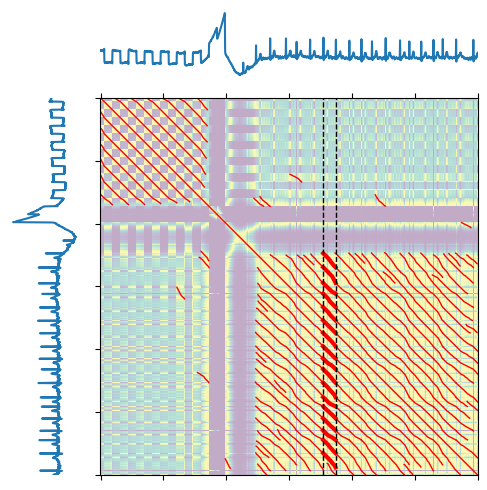

In [12]:
# b, e, fitness, coverage, score
print(candidate)
b, e = int(candidate[0]), int(candidate[1])

import locomotif.visualize as visualize

fig, axs, _ = visualize.plot_sm(series, series, lcm._sm, matshow_kwargs={'alpha': 0.33})
visualize.plot_local_warping_paths(axs, lcm.get_paths(), lw=1)

induced_paths = lcm.induced_paths(b, e)
visualize.plot_local_warping_paths(axs, induced_paths, lw=3)

axs[3].axvline(b, lw=1, c='k', ls='--')
axs[3].axvline(e, lw=1, c='k', ls='--')

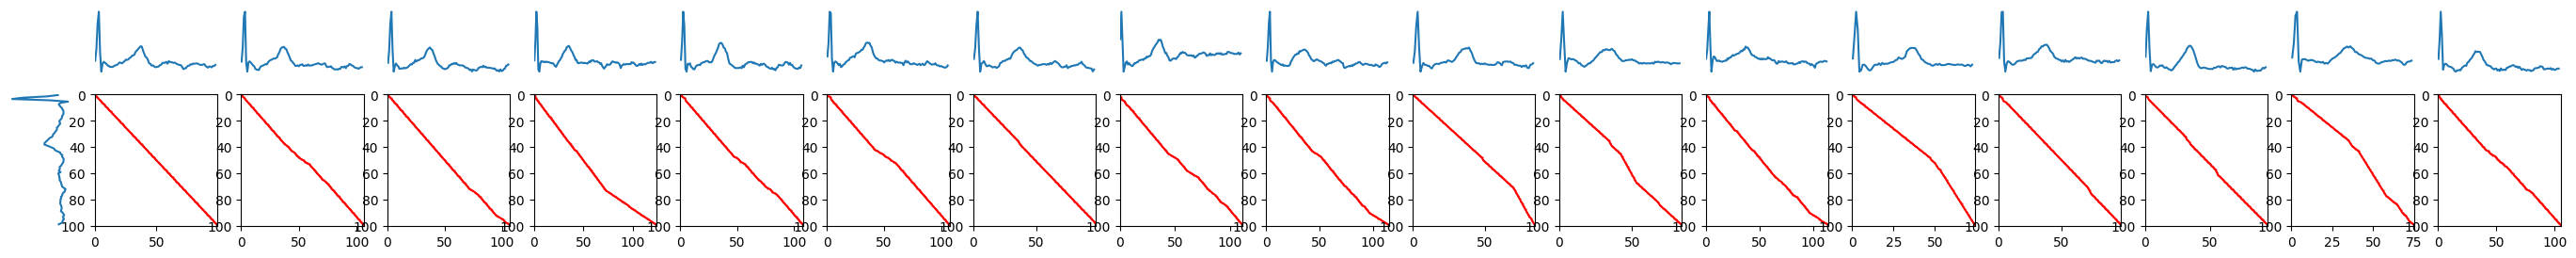

In [13]:
import matplotlib.pyplot as plt

k = len(motif_set)
fig, ax = plt.subplots(2, k+1, figsize=(2 * (0.5 + k), 2*1.5), width_ratios=[0.5] ++ k * [1], height_ratios=[0.5, 1])
ax[0, 0].set_axis_off()

candidate_subsq = series[b:e, :]
ax[1, 0].plot(-candidate_subsq, range(len(candidate_subsq), 0, -1))
ax[1, 0].set_ylim([-0.5, e-b+0.5])
ax[1, 0].set_axis_off()

for i, path in enumerate(induced_paths):
    (bm, em) = path[0][0], path[-1][0]
    
    ax[0, i+1].plot(series[bm:em, :])
    ax[0, i+1].set_xlim([-0.5, em-bm+0.5])
    ax[0, i+1].set_axis_off()

    ax[1, i+1].invert_yaxis()
    ax[1, i+1].plot(path[:, 0]-bm, path[:, 1]-b, c='r', ls='-', marker='.', markersize=1)
    
    ax[1, i+1].set_ylim([e-b , 0])
    ax[1, i+1].set_xlim([0, em-bm])